In [48]:
import googleapiclient.discovery
from IPython.display import JSON, display
import json
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
f1 = open('apikey.txt', 'r')
api_key = f1.read()

api_service_name = "youtube"
api_version = "v3"

In [3]:
!pip install --upgrade google-api-python-client

In [4]:
channel_ids = ['UCX6OQ3DkcsbYNE6H8uQQuVA'] # MR Beast channelid # Add more channel ids

In [5]:
youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=api_key)

request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
response = request.execute()

print(json.dumps(response, indent=2))
#display(JSON(response))

{
  "kind": "youtube#channelListResponse",
  "etag": "l0laq8tpA_8Bo4Uv4GZN_2W4G_Y",
  "pageInfo": {
    "totalResults": 1,
    "resultsPerPage": 5
  },
  "items": [
    {
      "kind": "youtube#channel",
      "etag": "US_QN5lYOWJ5ZHK8DGqTiQvlVGU",
      "id": "UCX6OQ3DkcsbYNE6H8uQQuVA",
      "snippet": {
        "title": "MrBeast",
        "description": "Go Watch Beast Games! https://unfur.ly/BeastGames\nSUBSCRIBE FOR A COOKIE!\n\nAccomplishments:\n- Raised $20,000,000 To Plant 20,000,000 Trees\n- Removed 30,000,000 pounds of trash from the ocean\n- Helped 2,000 people walk again\n- Helped 1,000 blind people see\n- Helped 1,000 deaf people hear\n- Built wells in Africa\n- Built and gave away 100 houses\n- Adopted every dog in a shelter (twice)\n- Given millions to charity\n- Started my own snack company Feastables\n- Started my own software company Viewstats\n- Started Lunchly, a tasty, better-for-you lunch option\n- Gave away a private island (twice)\n- Gave away 1 million meals\n-

In [6]:
channels_data = []
def get_channel_stats(youtube, channel_id):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()
    items = response['items']
    for item in items:
        channel_stats = {
                         'channel_name' : item['snippet']['title'],
                         'subscribers' : item['statistics']['subscriberCount'],
                         'views' : item['statistics']['viewCount'],
                         'total_videos' : item['statistics']['videoCount'],
                         'playlist_id' : item['contentDetails']['relatedPlaylists']['uploads']
                        }
        channels_data.append(channel_stats)
    return channels_data

In [7]:
all_channel_data =[]
for channel_id in channel_ids:
    all_channel_data.append(get_channel_stats(youtube, channel_id))

In [8]:
all_channel_data

[[{'channel_name': 'MrBeast',
   'subscribers': '346000000',
   'views': '70328115448',
   'total_videos': '843',
   'playlist_id': 'UUX6OQ3DkcsbYNE6H8uQQuVA'}]]

In [9]:
playlist_ids = []
for channel_data in all_channel_data:
    for k,v in channel_data[0].items():
      if k == 'playlist_id':
        playlist_ids.append(v)

def getVideoIds(youtube, playlist_id):
  videoIds = []
  for playlist_id in playlist_ids:
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults=50
      )
    response = request.execute()
    items = response.get('items')
    for item in items:
        video_id = item['contentDetails']['videoId']
        videoIds.append(video_id)

    nextPageToken = response.get('nextPageToken')
    while nextPageToken is not None:
      request = youtube.playlistItems().list(
        part = "snippet,contentDetails",
        playlistId = playlist_id,
        maxResults = 50,
        pageToken = nextPageToken
      )
      response = request.execute()
      items = response.get('items')
      for item in items:
          video_id = item['contentDetails']['videoId']
          videoIds.append(video_id)
      nextPageToken = response.get('nextPageToken')
    return videoIds

videoIds = getVideoIds(youtube, playlist_ids)
print(len(videoIds))

843


In [10]:
videoIds[0]
request = youtube.videos().list(
        part="contentDetails, snippet, statistics, topicDetails",
        id=videoIds[:5]
    )
response = request.execute()

print(json.dumps(response, indent=2))

{
  "kind": "youtube#videoListResponse",
  "etag": "PA-KS8E6l-Uu0A2_KEMvh1ise1g",
  "items": [
    {
      "kind": "youtube#video",
      "etag": "Bh9j99qI5yB4XfGgZ5FuORJmp6c",
      "id": "MFpWEKN9c6Y",
      "snippet": {
        "publishedAt": "2025-01-21T17:00:03Z",
        "channelId": "UCX6OQ3DkcsbYNE6H8uQQuVA",
        "title": "Last Person Hanging Wins $10,000",
        "description": "",
        "thumbnails": {
          "default": {
            "url": "https://i.ytimg.com/vi/MFpWEKN9c6Y/default.jpg",
            "width": 120,
            "height": 90
          },
          "medium": {
            "url": "https://i.ytimg.com/vi/MFpWEKN9c6Y/mqdefault.jpg",
            "width": 320,
            "height": 180
          },
          "high": {
            "url": "https://i.ytimg.com/vi/MFpWEKN9c6Y/hqdefault.jpg",
            "width": 480,
            "height": 360
          },
          "standard": {
            "url": "https://i.ytimg.com/vi/MFpWEKN9c6Y/sddefault.jpg",
            

In [11]:
def get_video_details(youtube, video_ids):
  videos = []
  i=0
  while i < len(videoIds):
    request = youtube.videos().list(
          part="contentDetails, snippet, statistics",
          id=videoIds[i:i+50]
      )
    response = request.execute()
    stats = {'snippet' :['publishedAt', 'title', 'channelTitle','tags','description'],
            'statistics' :['viewCount', 'likeCount', 'commentCount'],
            'contentDetails' :['duration','definition','caption']}

    items = response['items']
    for item in items:
      video = {}
      try:
        video['video_id'] = item['id']
      except:
        video['video_id'] = None

      for k in stats.keys():
        for v in stats[k]:
          try:
              video[v]=item[k][v]
          except:
              video[v] = None
      videos.append(video)
    i+=50
  return pd.DataFrame(videos)


In [12]:
videos_data = get_video_details(youtube, videoIds)
videos_data.head()

,video_id,publishedAt,title,channelTitle,tags,description,viewCount,likeCount,commentCount,duration,definition,caption
0,MFpWEKN9c6Y,2025-01-21T17:00:03Z,"Last Person Hanging Wins $10,000",MrBeast,None,,4593845,398083,1432,PT43S,hd,false
1,TRxMLLuWIhw,2025-01-17T17:00:00Z,Subscribe For An iPhone,MrBeast,None,Terms and Conditions: https://bit.ly/MrBeastIp...,24059274,2286177,94546,PT17S,hd,false
2,SM66GDRyIVY,2025-01-11T17:00:02Z,"I Helped 2,000 People Walk Again",MrBeast,None,Thank you for making this video possible\nROMP...,68347353,2384700,45185,PT15M31S,hd,true
3,EvqtfK_RaRg,2025-01-10T17:00:00Z,This obstacle course is WILD,MrBeast,None,,58770122,2032524,2970,PT32S,hd,false
4,3cWm9B_0_kI,2024-12-27T19:00:00Z,How Many People To Stop Ronaldo?,MrBeast,None,,152721813,6538125,15113,PT21S,hd,false


In [13]:
videos_data.shape

(843, 12)

In [14]:
comments = []
def get_channel_comments(youtube, videoIds):
  for video_id in videoIds:
    try:
      request = youtube.commentThreads().list(
              part="snippet, replies",
              videoId='TRxMLLuWIhw'
          )
      response = request.execute()
    except:
      continue
    items = response['items']
    # print(json.dumps(response, indent=2))
    for item in items:
      comment = item.get('snippet').get('topLevelComment').get('snippet').get('textOriginal')
      comment_entry = {'videoId' :video_id, 'comment':comment}
      comments.append(comment_entry)

  return pd.DataFrame(comments)

In [15]:
comments_df = get_channel_comments(youtube, videoIds)
comments_df.head()

,videoId,comment
0,MFpWEKN9c6Y,Please make sure you have an email address on ...
1,MFpWEKN9c6Y,Subed
2,MFpWEKN9c6Y,اتمنى ان ترسل لي ايفوم
3,MFpWEKN9c6Y,Yo
4,MFpWEKN9c6Y,Ya suscribi jaja espero tener surte 😅😅


In [16]:
videos_data.to_csv('videos_data.csv')
comments_df.to_csv('comments_data.csv')

https://www.youtube.com/watch?v=D56_Cx36oGY&list=PLbHrOSG7nVN1z4XoLX7_RC-WkgZHc3tnV&index=4

In [17]:
videos_data.isna().sum()

,0
video_id,0
publishedAt,0
title,0
channelTitle,0
tags,303
description,0
viewCount,0
likeCount,7
commentCount,1
duration,0


In [25]:
videos_data.dtypes

,0
video_id,object
publishedAt,"datetime64[ns, UTC]"
title,object
channelTitle,object
tags,object
description,object
viewCount,float64
likeCount,float64
commentCount,float64
duration,object


In [20]:
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
videos_data[numeric_cols] = videos_data[numeric_cols].apply(pd.to_numeric,errors = 'coerce', axis = 1)

In [28]:
videos_data['publishedAt'] = pd.to_datetime(videos_data['publishedAt'])
videos_data['publishedDayofweek'] = videos_data['publishedAt'].dt.dayofweek #datetime datatype can use dt to give day of the week. 0 for Monday and 6 for sunday
videos_data['publishedTime'] = videos_data['publishedAt'].dt.time

videos_data.head()

,video_id,publishedAt,title,channelTitle,tags,description,viewCount,likeCount,commentCount,duration,definition,caption,publishedDayofweek,publishedTime
0,MFpWEKN9c6Y,2025-01-21 17:00:03+00:00,"Last Person Hanging Wins $10,000",MrBeast,None,,4593845.0,398083.0,1432.0,PT43S,hd,false,1,17:00:03
1,TRxMLLuWIhw,2025-01-17 17:00:00+00:00,Subscribe For An iPhone,MrBeast,None,Terms and Conditions: https://bit.ly/MrBeastIp...,24059274.0,2286177.0,94546.0,PT17S,hd,false,4,17:00:00
2,SM66GDRyIVY,2025-01-11 17:00:02+00:00,"I Helped 2,000 People Walk Again",MrBeast,None,Thank you for making this video possible\nROMP...,68347353.0,2384700.0,45185.0,PT15M31S,hd,true,5,17:00:02
3,EvqtfK_RaRg,2025-01-10 17:00:00+00:00,This obstacle course is WILD,MrBeast,None,,58770122.0,2032524.0,2970.0,PT32S,hd,false,4,17:00:00
4,3cWm9B_0_kI,2024-12-27 19:00:00+00:00,How Many People To Stop Ronaldo?,MrBeast,None,,152721813.0,6538125.0,15113.0,PT21S,hd,false,4,19:00:00


In [32]:
!pip install isodate

In [33]:
import isodate

dur = isodate.parse_duration('P1W2DT6H21M32S')


800492.0


In [39]:
videos_data['durationSeconds'] = videos_data['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

In [40]:
videos_data.tail()

,video_id,publishedAt,title,channelTitle,tags,description,viewCount,likeCount,commentCount,duration,definition,caption,publishedDayofweek,publishedTime,durationSeconds
838,7qj3nuF9Dzw,2013-01-13 01:59:21+00:00,Most Epic minecraft skin EVER (Psy),MrBeast,"[psy, minecraft, epic, skin, most, ever]",Psy in minecraft!!! drop a like for psy's mo...,1129189.0,41926.0,3561.0,PT31S,hd,false,6,01:59:21,31.0
839,Y74b7WlcEpk,2013-01-12 23:35:45+00:00,More birds IN MINECRAFT!!,MrBeast,"[birds, minecraft, in, more, must, see, epic]",Basically what this mod does is adds more bird...,1273892.0,47237.0,3771.0,PT2M6S,hd,false,5,23:35:45,126.0
840,Z8nEEdXTaX0,2013-01-12 22:34:11+00:00,Boxy item mod Minecraft. EPIC,MrBeast,"[boxy, item, mod, minecraft, epic]",At the begining i said i was mrbeast6000.... i...,1501993.0,55684.0,4240.0,PT1M30S,hd,false,5,22:34:11,90.0
841,jP82d277Cc8,2012-03-09 23:29:03+00:00,Harry Potter Mod In Minecraft! EPIC MUST SEE M...,MrBeast,"[Harry Potter minecraft, minecraft, minecraft ...",One of the coolest mods i have ever seen\n\nMo...,5611838.0,NaN,9187.0,PT3M59S,hd,false,4,23:29:03,239.0
842,2XVcLrB7B3Y,2012-02-20 22:42:32+00:00,Worst Minecraft Saw Trap Ever???,MrBeast,"[minecraft, saw trap, minecraft saw trap, wors...",This is the worst saw trap ever done in minecr...,28577952.0,1255724.0,131130.0,PT2M37S,hd,false,0,22:42:32,157.0


In [42]:
videos_data['tagNumber'] = videos_data['tags'].apply(lambda x: 0 if x is None else len(x))

In [44]:
videos_data.tail()

,video_id,publishedAt,title,channelTitle,tags,description,viewCount,likeCount,commentCount,duration,definition,caption,publishedDayofweek,publishedTime,durationSeconds,tagNumber
838,7qj3nuF9Dzw,2013-01-13 01:59:21+00:00,Most Epic minecraft skin EVER (Psy),MrBeast,"[psy, minecraft, epic, skin, most, ever]",Psy in minecraft!!! drop a like for psy's mo...,1129189.0,41926.0,3561.0,PT31S,hd,false,6,01:59:21,31.0,6
839,Y74b7WlcEpk,2013-01-12 23:35:45+00:00,More birds IN MINECRAFT!!,MrBeast,"[birds, minecraft, in, more, must, see, epic]",Basically what this mod does is adds more bird...,1273892.0,47237.0,3771.0,PT2M6S,hd,false,5,23:35:45,126.0,7
840,Z8nEEdXTaX0,2013-01-12 22:34:11+00:00,Boxy item mod Minecraft. EPIC,MrBeast,"[boxy, item, mod, minecraft, epic]",At the begining i said i was mrbeast6000.... i...,1501993.0,55684.0,4240.0,PT1M30S,hd,false,5,22:34:11,90.0,5
841,jP82d277Cc8,2012-03-09 23:29:03+00:00,Harry Potter Mod In Minecraft! EPIC MUST SEE M...,MrBeast,"[Harry Potter minecraft, minecraft, minecraft ...",One of the coolest mods i have ever seen\n\nMo...,5611838.0,NaN,9187.0,PT3M59S,hd,false,4,23:29:03,239.0,6
842,2XVcLrB7B3Y,2012-02-20 22:42:32+00:00,Worst Minecraft Saw Trap Ever???,MrBeast,"[minecraft, saw trap, minecraft saw trap, wors...",This is the worst saw trap ever done in minecr...,28577952.0,1255724.0,131130.0,PT2M37S,hd,false,0,22:42:32,157.0,4


## **EDA Analysis**



<ipython-input-49-fd76265a52f1>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


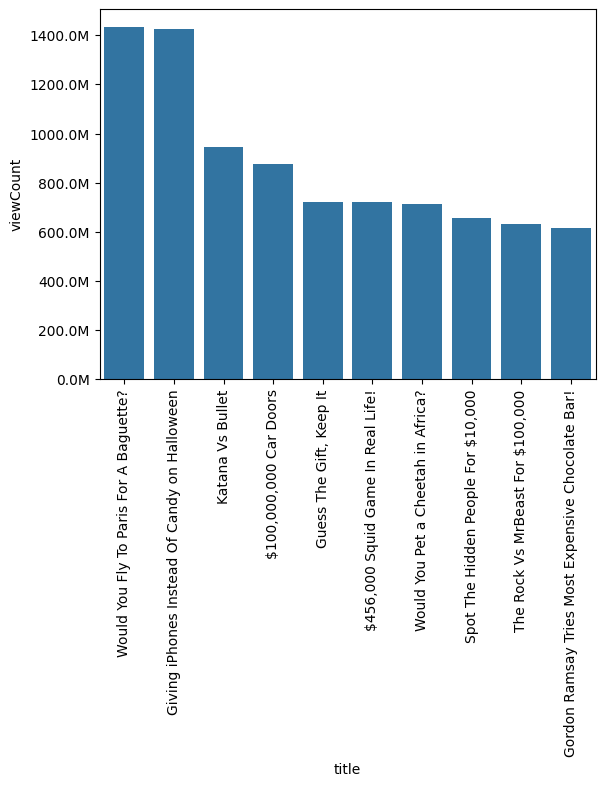

In [49]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = videos_data.sort_values('viewCount', ascending = False)[:10])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
formatter = ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M')  # Convert to millions
ax.yaxis.set_major_formatter(formatter)

<ipython-input-52-e9cdf959a009>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


[Text(0, 0, 'New Optic Gaming Gear Coming To Advanced Warfare, My Thoughts'),
 Text(1, 0, 'Crazy Nub Tub Reactions! Bo2 Fun!'),
 Text(2, 0, 'I Hate Spam On Youtube'),
 Text(3, 0, 'Watching Video Games Is A Waste Of Time????'),
 Text(4, 0, 'Remember When COD Was Fun?'),
 Text(5, 0, 'Insane Gun Sync - 7 Hours To Make'),
 Text(6, 0, 'How Much Money Does Tmartn Make?????'),
 Text(7, 0, 'Selling PS4 For $250 + Elgato For $100!'),
 Text(8, 0, 'Youtube Stat News - Vevo Gets 10 Bil. Views A Month, Channel Milestones, and more!'),
 Text(9, 0, 'Exility vs Dr.Pineapplez - Misleading Contest!')]

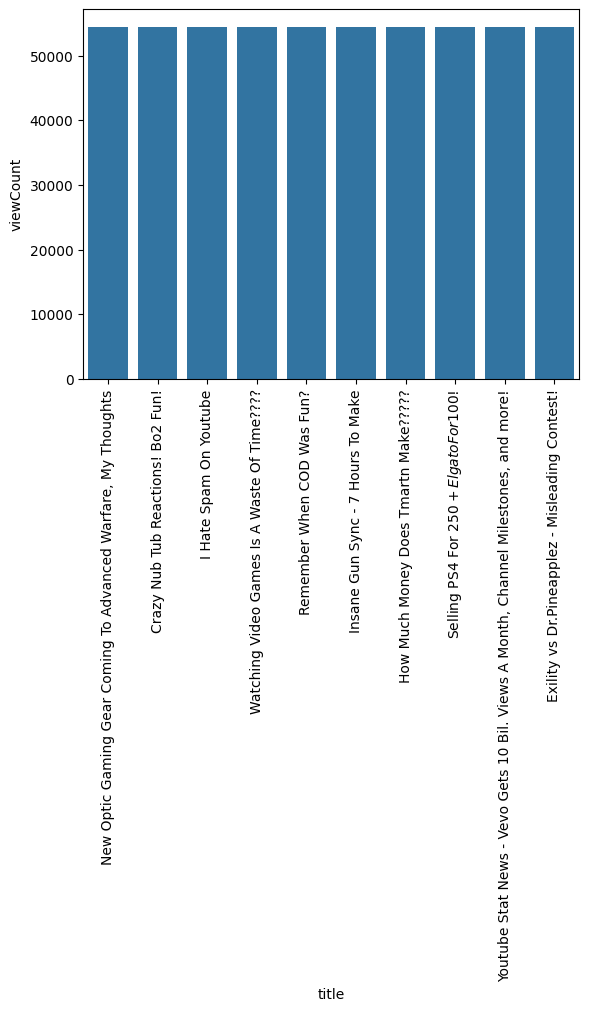

In [52]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = videos_data.sort_values('viewCount', ascending = True)[:10])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
# formatter = ticker.FuncFormatter(lambda x, _: f'{x/1e3:.1f}K')  # Convert to Thousands
# ax.yaxis.set_major_formatter(formatter)

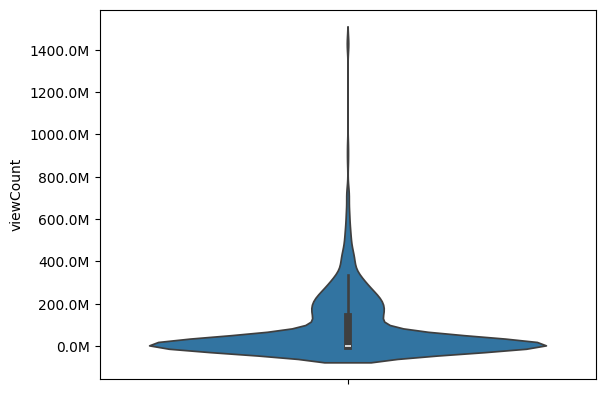

In [57]:
ax = sns.violinplot(videos_data['viewCount'])
formatter = ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M')  # Convert to millions
ax.yaxis.set_major_formatter(formatter)

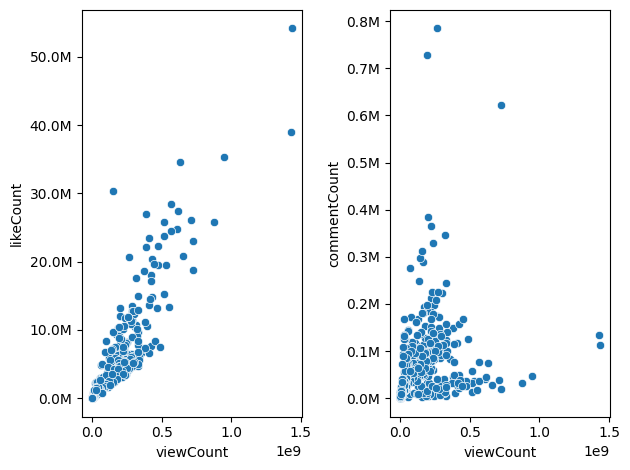

In [60]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(x = 'viewCount', y = 'likeCount', data = videos_data, ax = ax[0])
sns.scatterplot(x = 'viewCount', y = 'commentCount', data = videos_data, ax = ax[1])
formatter = ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M')  # Convert to millions
ax[0].yaxis.set_major_formatter(formatter)
ax[1].yaxis.set_major_formatter(formatter)

plt.tight_layout()

<Axes: xlabel='durationSeconds', ylabel='Count'>

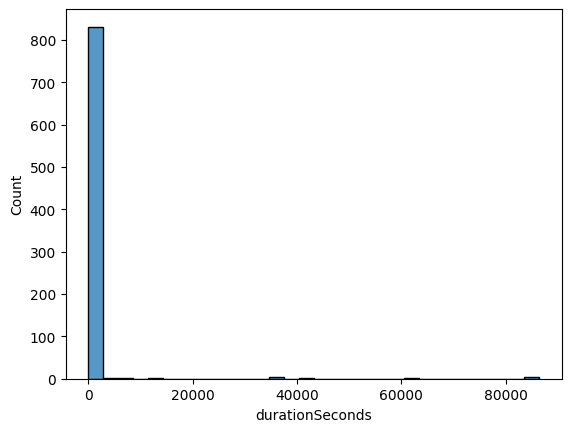

In [62]:
sns.histplot(data = videos_data, x = 'durationSeconds', bins = 30)

Try to get subscriber count after every video. Move the data to tableau for more analysis.